## Working with Transformers in the HuggingFace Ecosystem

In this laboratory exercise we will learn how to work with the HuggingFace ecosystem to adapt models to new tasks. As you will see, much of what is required is *investigation* into the inner-workings of the HuggingFace abstractions. With a little work, a little trial-and-error, it is fairly easy to get a working adaptation pipeline up and running.

### Exercise 1: Sentiment Analysis (warm up)

In this first exercise we will start from a pre-trained BERT transformer and build up a model able to perform text sentiment analysis. Transformers are complex beasts, so we will build up our pipeline in several explorative and incremental steps.

#### Exercise 1.1: Dataset Splits and Pre-trained model
There are a many sentiment analysis datasets, but we will use one of the smallest ones available: the [Cornell Rotten Tomatoes movie review dataset](cornell-movie-review-data/rotten_tomatoes), which consists of 5,331 positive and 5,331 negative processed sentences from the Rotten Tomatoes movie reviews.

**Your first task**: Load the dataset and figure out what splits are available and how to get them. Spend some time exploring the dataset to see how it is organized. Note that we will be using the [HuggingFace Datasets](https://huggingface.co/docs/datasets/en/index) library for downloading, accessing, splitting, and batching data for training and evaluation.

In [1]:
import numpy as np
from datasets import load_dataset, get_dataset_split_names
from transformers import AutoTokenizer, AutoModel
from transformers import pipeline
import torch
from transformers import DistilBertForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import AutoFeatureExtractor
from transformers import DistilBertModel, DistilBertTokenizer, EarlyStoppingCallback
from datasets import load_from_disk

#import evaluate
#import wandb

In [15]:
from datasets import load_dataset, get_dataset_split_names

# data loading
dataset_name= "cornell-movie-review-data/rotten_tomatoes"
ds_train = load_dataset(dataset_name, split="train")
ds_test = load_dataset(dataset_name, split="test")
ds_validation = load_dataset(dataset_name, split="validation")

print(ds_train)

Dataset({
    features: ['text', 'label'],
    num_rows: 8530
})


In [16]:
import random
idx = random.randint(0, ds_train.shape[0])
print(f"Text example: {ds_train['text'][idx]}")
print(f"Label example: {ds_train['label'][idx]}")

Text example: a touching , sophisticated film that almost seems like a documentary in the way it captures an italian immigrant family on the brink of major changes .
Label example: 1


#### Exercise 1.2: A Pre-trained BERT and Tokenizer

The model we will use is a *very* small BERT transformer called [Distilbert](https://huggingface.co/distilbert/distilbert-base-uncased) this model was trained (using self-supervised learning) on the same corpus as BERT but using the full BERT base model as a *teacher*.

**Your next task**: Load the Distilbert model and corresponding tokenizer. Use the tokenizer on a few samples from the dataset and pass the tokens through the model to see what outputs are provided. I suggest you use the [`AutoModel`](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html) class (and the `from_pretrained()` method) to load the model and `AutoTokenizer` to load the tokenizer).

In [17]:
from transformers import AutoTokenizer, AutoModel

model = AutoModel.from_pretrained("distilbert/distilbert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [18]:
print('######################## TOKENIZER ########################')
print(tokenizer)
print('\n######################## MODEL ########################')
print(model)

######################## TOKENIZER ########################
DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

######################## MODEL ###########

In [19]:
idx = 5
input = tokenizer(ds_train[idx]['text'], padding=True, return_tensors="pt")
output = model(**input)

print("Samlpe phrase:", ds_train['text'][idx])
print("Token IDs:", input["input_ids"], "\n")
print(output)

Samlpe phrase: the film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .
Token IDs: tensor([[  101,  1996,  2143,  3640,  2070,  2307, 12369,  2046,  1996, 11265,
         10976,  4588,  9273,  3388,  1997,  2035,  5888,  1011,  1011,  2130,
          2216,  2040,  2031,  2584,  1996,  7619,  2327,  1997,  1996,  2208,
          1012,   102]]) 

BaseModelOutput(last_hidden_state=tensor([[[-0.1294, -0.1650, -0.0116,  ...,  0.0188,  0.5275,  0.3162],
         [-0.1010, -0.4746,  0.0064,  ...,  0.2497,  1.0458, -0.1916],
         [ 0.2940, -0.0451, -0.2083,  ...,  0.0923,  0.4090,  0.0165],
         ...,
         [ 0.2519, -0.5503,  0.3750,  ...,  0.0188,  0.3540,  0.4099],
         [ 0.8860,  0.0582, -0.1454,  ...,  0.0152, -0.4178, -0.2869],
         [ 0.7707,  0.2344,  0.0241,  ...,  0.0782, -0.2970, -0.0993]]],
       grad_fn=<NativeLayerNormBackward0>), hidden_states=None, attentions=None)


In [20]:
idx = 870
input = tokenizer(ds_train[idx]['text'], padding=True, return_tensors="pt")
output = model(**input)

print("Sample phrase:", ds_train['text'][idx])
print("Token IDs:", input["input_ids"], "\n")
print(output)

Sample phrase: the story , like life , refuses to be simple , and the result is a compelling slice of awkward emotions .
Token IDs: tensor([[  101,  1996,  2466,  1010,  2066,  2166,  1010, 10220,  2000,  2022,
          3722,  1010,  1998,  1996,  2765,  2003,  1037, 17075, 14704,  1997,
          9596,  6699,  1012,   102]]) 

BaseModelOutput(last_hidden_state=tensor([[[-0.1782, -0.1238, -0.0865,  ..., -0.0867,  0.4100,  0.3362],
         [-0.2704, -0.0790, -0.4201,  ...,  0.1000,  0.8274, -0.1355],
         [ 0.0728, -0.2583, -0.1176,  ..., -0.1747,  0.1437, -0.2213],
         ...,
         [-0.4658,  0.1920,  0.0862,  ..., -0.2875,  0.1009, -0.1235],
         [ 0.7563,  0.0812, -0.2714,  ...,  0.3315, -0.5503, -0.4448],
         [-0.5857, -0.1106,  0.3320,  ...,  0.0919,  0.3582, -0.0365]]],
       grad_fn=<NativeLayerNormBackward0>), hidden_states=None, attentions=None)


#### Exercise 1.3: A Stable Baseline

In this exercise I want you to:
1. Use Distilbert as a *feature extractor* to extract representations of the text strings from the dataset splits;
2. Train a classifier (your choice, by an SVM from Scikit-learn is an easy choice).
3. Evaluate performance on the validation and test splits.

These results are our *stable baseline* -- the **starting** point on which we will (hopefully) improve in the next exercise.

**Hint**: There are a number of ways to implement the feature extractor, but probably the best is to use a [feature extraction `pipeline`](https://huggingface.co/tasks/feature-extraction). You will need to interpret the output of the pipeline and extract only the `[CLS]` token from the *last* transformer layer. *How can you figure out which output that is?*

In [21]:
def get_cls_embeddings(texts, tokenizer, model, batch_size=16, device="cpu"):
    """
    Converte una lista di testi in embeddings CLS usando DistilBERT.
    """
    all_embeddings = []
    model.to(device)
    model.eval()

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        encoded = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
        encoded = {k: v.to(device) for k, v in encoded.items()}

        with torch.no_grad():
            outputs = model(**encoded)
            cls_embeddings = outputs.last_hidden_state[:,0,:]  # [CLS]
        
        all_embeddings.append(cls_embeddings.cpu().numpy())

    return np.vstack(all_embeddings)

In [20]:
if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

train_texts, train_labels = ds_train["text"], ds_train["label"]
val_texts, val_labels = ds_validation["text"], ds_validation["label"]
test_texts, test_labels = ds_test["text"], ds_test["label"]

# Estrazione embeddings CLS
X_train = get_cls_embeddings(train_texts, tokenizer, model, device=DEVICE)
X_val = get_cls_embeddings(val_texts, tokenizer, model, device=DEVICE)
X_test = get_cls_embeddings(test_texts, tokenizer, model, device=DEVICE)

In [28]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

clf = LinearSVC()
clf.fit(X_train, train_labels)

val_preds = clf.predict(X_val)
test_preds = clf.predict(X_test)

print("Validation accuracy:", accuracy_score(val_labels, val_preds))
print("Test accuracy:", accuracy_score(test_labels, test_preds))
print("\nClassification report (test):\n", classification_report(test_labels, test_preds))


Validation accuracy: 0.8217636022514071
Test accuracy: 0.798311444652908

Classification report (test):
               precision    recall  f1-score   support

           0       0.79      0.81      0.80       533
           1       0.81      0.78      0.80       533

    accuracy                           0.80      1066
   macro avg       0.80      0.80      0.80      1066
weighted avg       0.80      0.80      0.80      1066



-----
### Exercise 2: Fine-tuning Distilbert

In this exercise we will fine-tune the Distilbert model to (hopefully) improve sentiment analysis performance.

#### Exercise 2.1: Token Preprocessing

The first thing we need to do is *tokenize* our dataset splits. Our current datasets return a dictionary with *strings*, but we want *input token ids* (i.e. the output of the tokenizer). This is easy enough to do my hand, but the HugginFace `Dataset` class provides convenient, efficient, and *lazy* methods. See the documentation for [`Dataset.map`](https://huggingface.co/docs/datasets/v3.5.0/en/package_reference/main_classes#datasets.Dataset.map).

**Tip**: Verify that your new datasets are returning for every element: `text`, `label`, `intput_ids`, and `attention_mask`.

In [22]:
def tokenize_function(data):
    return tokenizer(data["text"], truncation=True)

tokenized_ds_train = ds_train.map(tokenize_function, batched=True)
tokenized_ds_validation = ds_validation.map(tokenize_function, batched=True)
tokenized_ds_test = ds_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [23]:
idx = 0
print('Before processing:', ds_train[idx].keys())
print('After processing:', tokenized_ds_train[idx].keys())

Before processing: dict_keys(['text', 'label'])
After processing: dict_keys(['text', 'label', 'input_ids', 'attention_mask'])


In [24]:
print('Train set elements:', tokenized_ds_train[idx].keys())
print('Validation set elements:', tokenized_ds_validation[idx].keys())
print('Test set elements:', tokenized_ds_test[idx].keys())

Train set elements: dict_keys(['text', 'label', 'input_ids', 'attention_mask'])
Validation set elements: dict_keys(['text', 'label', 'input_ids', 'attention_mask'])
Test set elements: dict_keys(['text', 'label', 'input_ids', 'attention_mask'])


#### Exercise 2.2: Setting up the Model to be Fine-tuned

In this exercise we need to prepare the base Distilbert model for fine-tuning for a *sequence classification task*. This means, at the very least, appending a new, randomly-initialized classification head connected to the `[CLS]` token of the last transformer layer. Luckily, HuggingFace already provides an `AutoModel` for just this type of instantiation: [`AutoModelForSequenceClassification`](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#automodelforsequenceclassification). You will want you instantiate one of these for fine-tuning.

In [25]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Exercise 2.3: Fine-tuning Distilbert

Finally. In this exercise you should use a HuggingFace [`Trainer`](https://huggingface.co/docs/transformers/main/en/trainer) to fine-tune your model on the Rotten Tomatoes training split. Setting up the trainer will involve (at least):


1. Instantiating a [`DataCollatorWithPadding`](https://huggingface.co/docs/transformers/en/main_classes/data_collator) object which is what *actually* does your batch construction (by padding all sequences to the same length).
2. Writing an *evaluation function* that will measure the classification accuracy. This function takes a single argument which is a tuple containing `(logits, labels)` which you should use to compute classification accuracy (and maybe other metrics like F1 score, precision, recall) and return a `dict` with these metrics.  
3. Instantiating a [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.51.1/en/main_classes/trainer#transformers.TrainingArguments) object using some reasonable defaults.
4. Instantiating a `Trainer` object using your train and validation splits, you data collator, and function to compute performance metrics.
5. Calling `trainer.train()`, waiting, waiting some more, and then calling `trainer.evaluate()` to see how it did.

**Tip**: When prototyping this laboratory I discovered the HuggingFace [Evaluate library](https://huggingface.co/docs/evaluate/en/index) which provides evaluation metrics. However I found it to have insufferable layers of abstraction and getting actual metrics computed. I suggest just using the Scikit-learn metrics...

In [26]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # serve a creare bath dove le sequenze sono tutte della stessa lunghezza aggiungendo un padding dinamico che si adatta alla lunghezza della specifica sequenza

In [27]:
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score

def compute_metrics(p):
    logits, labels = p
    preds = np.argmax(logits, axis=-1)

    return {
        "balanced accuracy": balanced_accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="binary")
    }

In [28]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=50,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds_train,
    eval_dataset=tokenized_ds_validation,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()
trainer.evaluate()

/tmp/ipykernel_665103/817737219.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/gciacci/miniconda3/envs/transformers/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Balanced accuracy,F1,Precision,Recall
1,0.445800,0.335623,0.839587,0.839301,0.842025,0.797373
2,0.218900,0.435894,0.824578,0.824481,0.825294,0.848030
3,0.115900,0.540147,0.833021,0.831712,0.843711,0.744841
4,0.065800,0.570677,0.846154,0.846110,0.846549,0.829268
5,0.031600,0.901184,0.803002,0.799839,0.823445,0.928705
6,0.034000,0.790024,0.834897,0.834850,0.835279,0.851782
7,0.025100,0.875973,0.828330,0.828220,0.829175,0.803002


/home/gciacci/miniconda3/envs/transformers/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/gciacci/miniconda3/envs/transformers/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/gciacci/miniconda3/envs/transformers/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/gciacci/miniconda3/envs/transformers/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return

{'eval_loss': 0.5706773400306702,
 'eval_balanced accuracy': 0.8461538461538461,
 'eval_f1': 0.8461099687332752,
 'eval_precision': 0.8465490811058447,
 'eval_recall': 0.8292682926829268,
 'eval_runtime': 1.9863,
 'eval_samples_per_second': 536.684,
 'eval_steps_per_second': 4.531,
 'epoch': 7.0}

-----
### Exercise 3: Choose at Least One


#### Exercise 3.2: Fine-tuning a CLIP Model (harder)

Use a (small) CLIP model like [`openai/clip-vit-base-patch16`](https://huggingface.co/openai/clip-vit-base-patch16) and evaluate its zero-shot performance on a small image classification dataset like ImageNette or TinyImageNet. Fine-tune (using a parameter-efficient method!) the CLIP model to see how much improvement you can squeeze out of it.

**Note**: There are several ways to adapt the CLIP model; you could fine-tune the image encoder, the text encoder, or both. Or, you could experiment with prompt learning.

**Tip**: CLIP probably already works very well on ImageNet and ImageNet-like images. For extra fun, look for an image classification dataset with different image types (e.g. *sketches*).

In [2]:
from datasets import load_dataset

# data loading
dataset_name = "Sijuade/ImageNette"
dataset = load_dataset(dataset_name)
ds_train = load_dataset(dataset_name, split="train")
ds_validation = load_dataset(dataset_name, split="validation")

print(ds_train)

Dataset({
    features: ['image', 'label'],
    num_rows: 9469
})


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

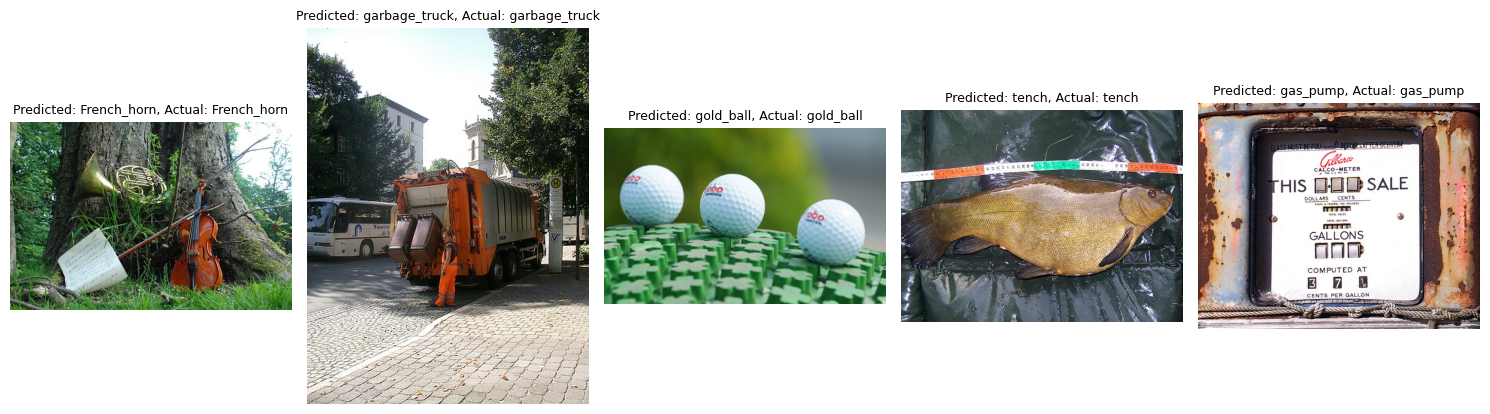

In [4]:
import torch
import matplotlib.pyplot as plt
from transformers import CLIPModel, CLIPProcessor
import random

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model_name = "openai/clip-vit-base-patch16"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

subcategories = dataset["train"].features["label"].names
text_inputs = processor(
    text=[f"a photo of {c}" for c in subcategories],
    return_tensors="pt",
    padding=True
).to(device)

indices = [random.randint(0, len(dataset["train"])-1) for _ in range(5)]

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, idx in enumerate(indices):
    example = dataset["train"][idx]
    image = example["image"]
    subcategory = dataset["train"].features["label"].int2str(example["label"])  # label originale

    image_input = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        image_features = model.get_image_features(**image_input)
        text_features = model.get_text_features(**text_inputs)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, top_idx = similarity[0].topk(1)

    axes[i].imshow(image)
    axes[i].set_title(f"Predicted: {subcategories[top_idx[0]]}, Actual: {subcategory}", fontsize=9)
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [4]:
from src.clip_utils import zeroshot_clip

zs_acc = zeroshot_clip(dataset)
print(f'Zero shot accuracy: {round(zs_acc*100, 2)} %')

Zero shot accuracy: 98.46 %


In [5]:
import torch
import torch.nn as nn
import numpy as np
from datasets import load_dataset
from transformers import CLIPModel, AutoProcessor, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
from sklearn.metrics import accuracy_score, f1_score
from src.clip_utils import CLIPForClassification

class_names = ds_train.features['label'].names
id2label = {i: name for i, name in enumerate(class_names)}
label2id = {name: i for i, name in enumerate(class_names)}

processor = AutoProcessor.from_pretrained(model_name)

def transform_images(examples):
    images = [img.convert("RGB") for img in examples["image"]]
    inputs = processor(images=images, return_tensors="pt")
    inputs['labels'] = examples['label']
    return inputs

ds_train.set_transform(transform_images)
ds_validation.set_transform(transform_images)


num_labels = len(class_names)

base_model = CLIPModel.from_pretrained(model_name)
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    # Applichiamo LoRA solo ai layer di attenzione del modello visivo
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
)

peft_model = get_peft_model(base_model, lora_config)
peft_model.print_trainable_parameters()

model_ft = CLIPForClassification(peft_model, num_labels).to(device)

training_args = TrainingArguments(
    #output_dir="./clip-finetuned-ImageNet",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    learning_rate=5e-5,
    logging_steps=50, 
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    remove_unused_columns=False, 
    report_to="none",
)

def evaluate_metrics(p):
    logits, labels = p
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }

trainer = Trainer(
    model=model_ft,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_validation,
    compute_metrics=evaluate_metrics,
)

print("\nInizio del fine-tuning di CLIP con LoRA...")
trainer.train()

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

trainable params: 983,040 || all params: 150,603,777 || trainable%: 0.6527

Inizio del fine-tuning di CLIP con LoRA...


/home/gciacci/miniconda3/envs/transformers/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.704000,0.892976,0.973559,0.973418
2,0.463100,0.313966,0.986667,0.986667
3,0.247500,0.236531,0.988927,0.988937


/home/gciacci/miniconda3/envs/transformers/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/gciacci/miniconda3/envs/transformers/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=444, training_loss=0.8140646165555662, metrics={'train_runtime': 1012.7549, 'train_samples_per_second': 28.049, 'train_steps_per_second': 0.438, 'total_flos': 0.0, 'train_loss': 0.8140646165555662, 'epoch': 3.0})

### Tiny Imagenet

In [6]:
from datasets import load_dataset

# data loading
dataset_name= "slegroux/tiny-imagenet-200-clean"
#dataset_name = "Sijuade/ImageNette"
dataset = load_dataset(dataset_name)
ds_train = load_dataset(dataset_name, split="train")
#ds_test = load_dataset(dataset_name, split="test")
ds_validation = load_dataset(dataset_name, split="validation")

In [8]:
from src.clip_tiny import create_readable_id2label, add_human_labels, zeroshot_clip

# Mapping human-readable labels
readable_id2label = create_readable_id2label(dataset)
dataset = add_human_labels(dataset, readable_id2label)

# Valutazione zero-shot
zs_acc = zeroshot_clip(dataset)
print(f"Zero-shot accuracy: {zs_acc*100:.2f}%")


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Zero-shot accuracy: 57.14%


In [11]:
num_labels = len(readable_id2label)

base_model = CLIPModel.from_pretrained(model_name)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj", "k_proj"], # Applichiamo LoRA ai layer di attenzione
    lora_dropout=0.1,
    bias="none",
)

peft_model = get_peft_model(base_model, lora_config)
print("\nParametri addestrabili dopo aver applicato LoRA:")
peft_model.print_trainable_parameters()

DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

ds_train.set_transform(transform_images)
ds_validation.set_transform(transform_images)

model_ft = CLIPForClassification(peft_model, num_labels).to(DEVICE)

training_args = TrainingArguments(
    #output_dir="./clip-finetuned-ImageNet",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    learning_rate=5e-5,
    logging_steps=50, 
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    remove_unused_columns=False, 
    report_to="none",
)

def evaluate_metrics(p):
    logits, labels = p
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }

trainer = Trainer(
    model=model_ft,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_validation,
    compute_metrics=evaluate_metrics,
)


print("\nInizio del fine-tuning di CLIP con LoRA su Tiny-ImageNet...")
trainer.train()

final_metrics = trainer.evaluate()
print("\nValutazione finale del modello fine-tuned:")
print(final_metrics)


Parametri addestrabili dopo aver applicato LoRA:
trainable params: 1,474,560 || all params: 151,095,297 || trainable%: 0.9759

Inizio del fine-tuning di CLIP con LoRA su Tiny-ImageNet...


/home/gciacci/miniconda3/envs/transformers/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,3.110800,3.064905,0.570585,0.544035
2,2.300100,2.283081,0.658790,0.640418
3,2.007800,2.059202,0.682624,0.667448


/home/gciacci/miniconda3/envs/transformers/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/gciacci/miniconda3/envs/transformers/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/gciacci/miniconda3/envs/transformers/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Valutazione finale del modello fine-tuned:
{'eval_loss': 2.059201717376709, 'eval_accuracy': 0.6826237522917091, 'eval_f1': 0.6674484196134627, 'eval_runtime': 56.2745, 'eval_samples_per_second': 87.233, 'eval_steps_per_second': 1.368, 'epoch': 3.0}
